# Indentifying Stress Factors in Rainbow Trouts - ML

In [2]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme()
from tqdm import tqdm

In [3]:
from sklearn.decomposition import KernelPCA, PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

SEED = 32

## Data - USDA
Performing basic cleanup and organization.
* Fishes belonging to the following categories: Control(con), Crowded(cro), High Salinity(hs), High temperature(ht), Low Temperature(lt) and Reused Water(rw).
* The dataset was transposed and renamed to become organized.
* The columns are the transcripts obtained from the fish. The prefix is the gene whereas, the suffix is the transcript number.

In [4]:
%%time
dataPath = './data/TPM_stress_USDA.xlsx'
columns = ['GeneExp']+[f"con{i}" for i in range(0,10)]+[f"cro{i}" for i in range(0, 6)]+[f"hs{i}" for i in range(0, 6)]+[f"ht{i}" for i in range(0, 6)]+[f"lt{i}" for i in range(0, 6)]+[f"rw{i}" for i in range(0, 6)]

tankColums = [f"con" for i in range(0,10)]+[f"cro" for i in range(0, 6)]+[f"hs" for i in range(0, 6)]+[f"ht" for i in range(0, 6)]+[f"lt" for i in range(0, 6)]+[f"rw" for i in range(0, 6)]

colDefMap = {'con':"Control", 'cro':"Crowded", "hs": "High Salinity", "ht": "High Temp", "lt": "Low Temp", 'rw': "Reu"}

# data = pd.read_excel(dataPath, nrows = 1000)
data = pd.read_excel(dataPath)

data.columns = columns
data = data.set_index('GeneExp').T

tankColums = [f"con" for i in range(0,10)]+[f"cro" for i in range(0, 6)]+[f"hs" for i in range(0, 6)]+[f"ht" for i in range(0, 6)]+[f"lt" for i in range(0, 6)]+[f"rw" for i in range(0, 6)]
data = data.assign(tank = tankColums)

print(data.shape)
data.head()

(40, 125909)
CPU times: user 20.5 s, sys: 267 ms, total: 20.8 s
Wall time: 20.8 s


GeneExp,4ebp2_1,5ntc_1,aacs_1,aadac_1,aadacl4_1,aagab_1,aakb1_1,aakb1_2,aakb1_3,aakb1_4,...,zwilch_2,zwilch_3,zwilch_4,zyg11_1,zyx_1,zyx_2,zzef1_1,zzef1_2,zzef1_3,tank
con0,25.225544,28.080450,2.732412,2.577981,1.763941,2.941886,57.036954,0.0,0.0,0.0,...,0.315159,0.506264,0.648684,20.875030,6.120552,16.849759,0.939789,0.999776,1.047765,con
con1,26.183206,27.814776,2.627333,2.488354,1.151104,3.088248,50.187026,0.0,0.0,0.0,...,0.537108,0.450512,0.495588,20.891255,6.146838,17.194558,0.937600,0.880660,1.040090,con
con2,24.462669,30.805397,2.260763,2.257356,1.382630,3.376831,51.169195,0.0,0.0,0.0,...,0.335363,0.551145,0.793690,19.433228,10.574061,13.420285,0.886052,0.829211,0.852616,con
con3,25.182863,29.473753,2.413444,2.288551,1.275375,3.316769,52.491676,0.0,0.0,0.0,...,0.550434,0.514201,0.492439,19.485679,6.131069,17.384730,0.945092,0.839348,0.902134,con
con4,26.305005,18.204322,2.807522,2.990708,0.949599,3.221152,47.154350,0.0,0.0,0.0,...,0.477111,0.442123,0.387635,19.494654,6.341428,17.291068,0.748626,0.799147,0.698106,con


In [5]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 40 entries, con0 to rw5
Columns: 125909 entries, 4ebp2_1 to tank
dtypes: float64(125908), object(1)
memory usage: 38.4 MB


In [6]:
# Removing columns with mean 0
meanZeroCols = data.iloc[:,:-1].mean() == 0

meanZeroCols = meanZeroCols[meanZeroCols==True].index.tolist()
print(f"Number of columns with just 0: {len(meanZeroCols)}\nTotal Number of columns: {data.shape[1]}")
print(f"This is {(len(meanZeroCols)/data.shape[1])*100: .2f}% of all columns")
# data[meanZeroCols].mean()

Number of columns with just 0: 30013
Total Number of columns: 125909
This is  23.84% of all columns


In [7]:
data = data.loc[:, (data!=0).any(axis=0)]
data.head()

GeneExp,4ebp2_1,5ntc_1,aacs_1,aadac_1,aadacl4_1,aagab_1,aakb1_1,aakb1_6,aakb1_7,aakb1_8,...,zwilch_2,zwilch_3,zwilch_4,zyg11_1,zyx_1,zyx_2,zzef1_1,zzef1_2,zzef1_3,tank
con0,25.225544,28.080450,2.732412,2.577981,1.763941,2.941886,57.036954,0.000000,0.0,5.631537,...,0.315159,0.506264,0.648684,20.875030,6.120552,16.849759,0.939789,0.999776,1.047765,con
con1,26.183206,27.814776,2.627333,2.488354,1.151104,3.088248,50.187026,0.000000,0.0,6.048805,...,0.537108,0.450512,0.495588,20.891255,6.146838,17.194558,0.937600,0.880660,1.040090,con
con2,24.462669,30.805397,2.260763,2.257356,1.382630,3.376831,51.169195,4.817612,0.0,7.248526,...,0.335363,0.551145,0.793690,19.433228,10.574061,13.420285,0.886052,0.829211,0.852616,con
con3,25.182863,29.473753,2.413444,2.288551,1.275375,3.316769,52.491676,0.000000,0.0,7.837344,...,0.550434,0.514201,0.492439,19.485679,6.131069,17.384730,0.945092,0.839348,0.902134,con
con4,26.305005,18.204322,2.807522,2.990708,0.949599,3.221152,47.154350,0.000000,0.0,5.786782,...,0.477111,0.442123,0.387635,19.494654,6.341428,17.291068,0.748626,0.799147,0.698106,con


## Modelling Data - USDA

In [8]:
commonFeatures = []
with open("./primaryColumnList.txt", "r") as f:
  for line in f:
    commonFeatures.append(str(line.strip()))

In [9]:
%%time
dataModel = data.copy()
dataModel.replace({'tank':{'con':0, 'cro':1, "hs": 2, "ht": 3, "lt": 4, 'rw': 5}}, inplace=True)

xdata, ydata = dataModel.loc[:, commonFeatures], dataModel.iloc[:,-1]

sca = MinMaxScaler()
# sca = StandardScaler()

xdata_sca = sca.fit_transform(xdata)


# xtrain, xtest, ytrain, ytest = train_test_split(xdata, ydata, test_size=0.3, stratify=ydata, random_state=SEED)
# xtrain, xtest = np.array(xtrain), np.array(xtest)

xstrain, xstest, ytrain, ytest = train_test_split(xdata_sca, ydata, test_size=0.3, stratify=ydata, random_state=SEED)

print(xstrain.shape, xstest.shape)

<timed exec>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


(28, 69080) (12, 69080)
CPU times: user 259 ms, sys: 8.91 ms, total: 268 ms
Wall time: 267 ms


In [10]:
targetNames = ['control','crowded', 'high salinity', 'high temp', 'low temp', 'resued water']

## Data - UMD

In [11]:
%%time
dataPath = './data/TPM_stress_RedTrout.xlsx'

# data = pd.read_excel(dataPath, nrows = 100)
dataUMD = pd.read_excel(dataPath)

CPU times: user 38.9 s, sys: 337 ms, total: 39.3 s
Wall time: 39.3 s


In [12]:
%%time

colsTemp = ['idx']+['CTRL']*(dataUMD.shape[1]//2)+['HEAT']*(dataUMD.shape[1]//2)

dataUMD.columns = colsTemp
dataUMD.iloc[0,0] = 'DAY'

dataUMD = dataUMD.set_index("idx").T.reset_index(drop=False, names = 'GeneExp')#.set_index("DAY", append=True)
dataUMD.rename(columns={'GeneExp':'Group'}, inplace=True)
print(dataUMD.shape)

(72, 125910)
CPU times: user 413 ms, sys: 18.8 ms, total: 432 ms
Wall time: 430 ms


In [13]:
dataUMD.head()

idx,Group,DAY,4ebp2,5ntc,aacs,aadac,aadacl4,aagab,aakb1_1,aakb1_2,...,zwilch_1,zwilch_2,zwilch_3,zwilch_4,zyg11,zyx_1,zyx_2,zzef1_1,zzef1_2,zzef1_3
0,CTRL,Day 7,20.392085,5.01189,2.244453,0.783542,0.474814,1.52711,32.438119,0,...,0,1.508154,0.302833,0.484558,9.294329,4.216087,0,1.423811,1.684077,1.661112
1,CTRL,Day 1,27.289734,7.310938,2.958239,1.270043,0.841218,3.128293,43.348779,0,...,0.278156,0.607265,0.017884,0.008943,10.089153,5.1805,0.843944,2.746311,2.820902,3.003989
2,CTRL,Day 7,24.278669,6.795036,2.367945,0.872521,0.780329,1.737497,37.117946,0,...,0,1.419542,0.42495,0.493886,9.274609,4.752717,0,2.029312,1.88996,1.950927
3,CTRL,Day 3,20.71429,10.404623,2.90694,1.307162,0.486661,3.026489,28.212887,0,...,0.007786,0.558591,0.333669,0.411287,9.13582,7.467661,0.015257,2.265504,2.312579,2.436152
4,CTRL,Day 1,23.821724,6.310578,2.060801,1.290215,1.001488,2.70031,35.728362,0,...,0.591635,1.521557,0.036851,0.00737,8.732718,2.68104,1.912857,1.794056,1.98408,1.889068


In [14]:
dataUMD['Group'].value_counts()

Group
CTRL    36
HEAT    36
Name: count, dtype: int64

In [15]:
%%time
umdDataFeatures = dataUMD.columns.tolist()

commonFeaturesUMD = list(set(umdDataFeatures) & set(commonFeatures))

print(f"{len(commonFeatures)*100/len(umdDataFeatures):.2f}% of UMD data feature set")
print(f"{len(commonFeaturesUMD)*100/len(commonFeatures):.2f}% of the training data feature set (USDA)")

54.86% of UMD data feature set
71.48% of the training data feature set (USDA)
CPU times: user 9.71 ms, sys: 867 µs, total: 10.6 ms
Wall time: 10.6 ms


In [16]:
%%time
dataUMD.replace({'CTRL':0, 'HEAT':3}, inplace=True)

<timed eval>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


CPU times: user 2.56 s, sys: 71.1 ms, total: 2.63 s
Wall time: 2.62 s


---

In [24]:
def resultAnalysisFnx(ytrue,ypred,target_names=None):
    if target_names != None:
        print(classification_report(ytrue,ypred,target_names = target_names, zero_division=0))
    else:
        print(classification_report(ytrue,ypred, zero_division=0))

    conf_matrix = confusion_matrix(ytrue, ypred)
    plt.figure(figsize=(6, 4))
    if target_names != None:
        sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%', cmap='Blues', cbar=False, xticklabels=target_names,yticklabels=target_names, linewidths=0.8, linecolor='black')
    else:
        sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%', cmap='Blues', cbar=False, linewidths=0.8, linecolor='black', xticklabels=True, yticklabels=True)

    # sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    return classification_report(ytrue,ypred,output_dict=True, zero_division=0)

## Binary Classification Only

In [35]:
%%time
# Retraining Model on entire USDA data but just for control and heat groups

dataModel = data.copy()
dataModelBC = dataModel[(dataModel['tank'] == 'con') | (dataModel['tank'] == 'ht')]
dataModelBC.replace({'tank':{'con':0, 'cro':1, "hs": 2, "ht": 3, "lt": 4, 'rw': 5}}, inplace=True)

xdata, ydata = dataModelBC.loc[:, commonFeaturesUMD], dataModelBC.iloc[:,-1]

sca = StandardScaler()

xdata_sca = sca.fit_transform(xdata)

CPU times: user 217 ms, sys: 11 ms, total: 228 ms
Wall time: 227 ms


<timed exec>:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
<timed exec>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [36]:
# Testing on UMD data
xtest, ytest = dataUMD.loc[:, commonFeaturesUMD], dataUMD.iloc[:, 0]

### Naive Bayes

### Logistic Regression

In [37]:
%%time
logRes_clf = LogisticRegression(random_state=SEED)
logRes_clf.fit(xdata_sca, ydata)

CPU times: user 1min 2s, sys: 10.1 s, total: 1min 12s
Wall time: 9.32 s


LogisticRegression(random_state=32)

In [38]:
%%time
# xtest, ytest 
xtest_sca = sca.transform(xtest)
ypred = logRes_clf.predict(xtest_sca)

CPU times: user 631 ms, sys: 1.23 s, total: 1.86 s
Wall time: 255 ms


              precision    recall  f1-score   support

         CON       0.63      0.92      0.75        36
        HEAT       0.85      0.47      0.61        36

    accuracy                           0.69        72
   macro avg       0.74      0.69      0.68        72
weighted avg       0.74      0.69      0.68        72



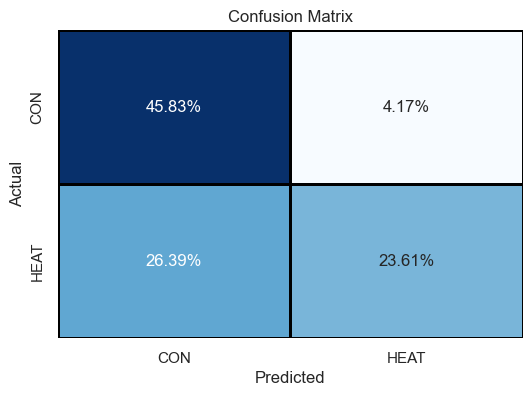

In [39]:
_ = resultAnalysisFnx(ytest, ypred, target_names=['CON', 'HEAT'])

### SVM

In [40]:
from sklearn.svm import SVC

In [42]:
%%time
# Linear Kernel
svm_clf = SVC(kernel='linear')
svm_clf.fit(xdata_sca, ydata)


CPU times: user 948 ms, sys: 191 ms, total: 1.14 s
Wall time: 165 ms


In [43]:
%%time
xtest_sca = sca.transform(xtest)
ypred = svm_clf.predict(xtest_sca)

CPU times: user 154 ms, sys: 6.35 ms, total: 161 ms
Wall time: 141 ms


              precision    recall  f1-score   support

         CON       0.67      0.86      0.76        36
        HEAT       0.81      0.58      0.68        36

    accuracy                           0.72        72
   macro avg       0.74      0.72      0.72        72
weighted avg       0.74      0.72      0.72        72



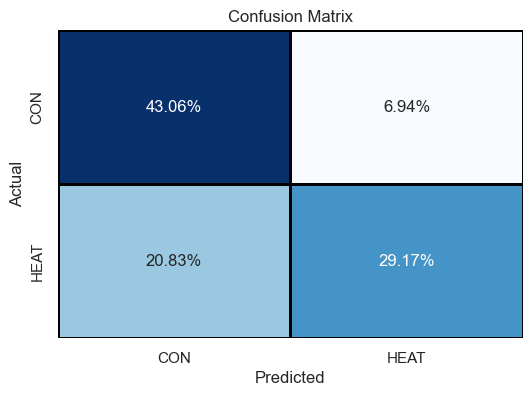

In [44]:
_ = resultAnalysisFnx(ytest, ypred, target_names=['CON', 'HEAT'])

In [45]:
%%time
# Radial Basis Function Kernel
svm_clf = SVC(kernel='rbf')
svm_clf.fit(xdata_sca, ydata)

ypred = svm_clf.predict(xtest_sca)

CPU times: user 466 ms, sys: 69.3 ms, total: 535 ms
Wall time: 90.7 ms


              precision    recall  f1-score   support

         CON       0.50      1.00      0.67        36
        HEAT       0.00      0.00      0.00        36

    accuracy                           0.50        72
   macro avg       0.25      0.50      0.33        72
weighted avg       0.25      0.50      0.33        72



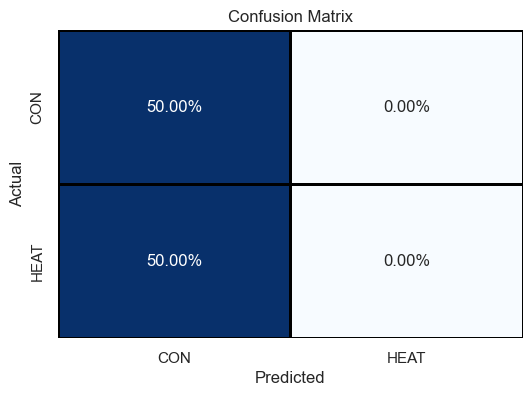

In [46]:
_ = resultAnalysisFnx(ytest, ypred, target_names=['CON', 'HEAT'])

In [47]:
%%time
# Sigmoid Kernel
svm_clf = SVC(kernel='sigmoid')
svm_clf.fit(xdata_sca, ydata)

ypred = svm_clf.predict(xtest_sca)

CPU times: user 323 ms, sys: 45.2 ms, total: 368 ms
Wall time: 70.7 ms


              precision    recall  f1-score   support

         CON       0.58      0.78      0.67        36
        HEAT       0.67      0.44      0.53        36

    accuracy                           0.61        72
   macro avg       0.62      0.61      0.60        72
weighted avg       0.62      0.61      0.60        72



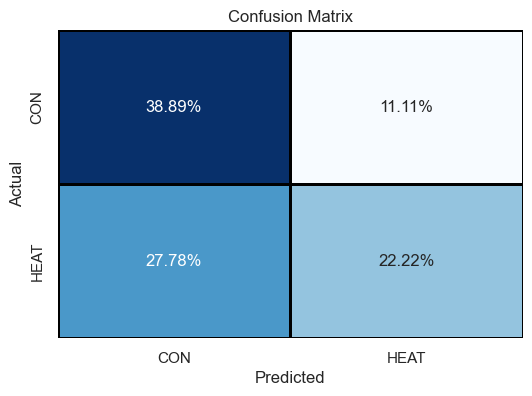

In [48]:
_ = resultAnalysisFnx(ytest, ypred, target_names=['CON', 'HEAT'])

## Feature Reduction

### Logistic Regression

In [52]:
from sklearn.feature_selection import RFE

In [53]:
%%time

dataModel = data.copy()
dataModel.replace({'tank':{'con':0, 'cro':1, "hs": 2, "ht": 3, "lt": 4, 'rw': 5}}, inplace=True)

xdata, ydata = dataModel.loc[:, commonFeaturesUMD], dataModel.iloc[:,-1]

sca = StandardScaler()
xdata_sca = sca.fit_transform(xdata)

xstrain, xstest, ytrain, ytest = train_test_split(xdata_sca, ydata, test_size=0.3, stratify=ydata, random_state=SEED)

logRes_clf = LogisticRegression(random_state=SEED)

selector = RFE(logRes_clf, n_features_to_select=10, step=0.1, verbose = 1)

selector.fit(xstrain, ytrain)

<timed exec>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


Fitting estimator with 49378 features.
Fitting estimator with 44441 features.
Fitting estimator with 39504 features.
Fitting estimator with 34567 features.
Fitting estimator with 29630 features.
Fitting estimator with 24693 features.
Fitting estimator with 19756 features.
Fitting estimator with 14819 features.
Fitting estimator with 9882 features.
Fitting estimator with 4945 features.
CPU times: user 7min 6s, sys: 1min 30s, total: 8min 37s
Wall time: 1min 7s


RFE(estimator=LogisticRegression(random_state=32), n_features_to_select=10,
    step=0.1, verbose=1)

In [59]:
feature_importance = selector.ranking_
selected_features = xdata.columns[selector.support_]

In [60]:
argSort = np.argsort(feature_importance)

In [61]:
feature_importance[argSort]
selected_features[argSort]

IndexError: index 33625 is out of bounds for axis 0 with size 10

In [64]:
len(feature_importance)
# len(selected_features)

49378

In [66]:
feature_importance
xdata.columns[argSort]

Index(['LOC110535792_11', 'LOC118965010_3', 'LOC110535792_12',
       'LOC118965010_2', 'LOC110524808_1', 'LOC110505306_10', 'LOC110509786_2',
       'LOC110532619_2', 'LOC110509786_3', 'LOC110533415_20',
       ...
       'appa_2', 'LOC110535491_1', 'csnk1a1_5', 'LOC110532372_2',
       'LOC110489175_2', 'LOC110505770_2', 'LOC110507011_1', 'LOC118936412_2',
       'csnk1g1_6', 'katnbl1_2'],
      dtype='object', name='GeneExp', length=49378)

## Logistic Regression - UMD Data
Model Validation on UMD data

In [45]:
%%time
# Retraining Model on entire USDA data

dataModel = data.copy()
dataModel.replace({'tank':{'con':0, 'cro':1, "hs": 2, "ht": 3, "lt": 4, 'rw': 5}}, inplace=True)

xdata, ydata = dataModel.loc[:, commonFeaturesUMD], dataModel.iloc[:,-1]

sca = StandardScaler()

xdata_sca = sca.fit_transform(xdata)

CPU times: user 213 ms, sys: 15.2 ms, total: 228 ms
Wall time: 226 ms


<timed exec>:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


In [ ]:
# Testing on UMD data
xtest, ytest = dataUMD.loc[:, commonFeaturesUMD], dataUMD.iloc[:, 0]

In [46]:
%%time
logRes_clf = LogisticRegression(random_state=SEED)
logRes_clf.fit(xdata_sca, ydata)

CPU times: user 1min, sys: 8.99 s, total: 1min 9s
Wall time: 9.16 s


LogisticRegression(random_state=32)

In [48]:
%%time
# xtest, ytest 
xtest_sca = sca.transform(xtest)
ypred = logRes_clf.predict(xtest_sca)

CPU times: user 138 ms, sys: 8.37 ms, total: 147 ms
Wall time: 145 ms


In [49]:
ypred

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 3, 1, 2, 3, 1, 0, 1, 1, 1, 3, 1, 1, 1,
       1, 3, 1, 1, 1, 1])